# How do the different analysis methods depend on the sampling rate?

Geoffrey Brookshire

Do the results of the different analysis methods depend on the sampling rate?

In [1]:
# Import libraries and set up analyses
%matplotlib inline

import os
os.chdir('..')

In [2]:
import yaml
import copy
import itertools
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import analysis
import simulate_behavior as behav
import simulate_experiments as sim_exp
from analysis_methods import shuff_time, alternatives, utils
from generate_plots import remove_topright_axes
from stat_report_helpers import chi_square_report

# Suppress maximum likelihood estimation convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

USE_CACHE = True  # Whether to use previously-saved simulations

behav_details = yaml.safe_load(open('behav_details.yaml'))

plt.ion()

plot_dir = 'plots/'
n_exp = 1000
behav_kwargs = {'noise_method': 'powerlaw',
                'exponent': 2}
osc_parameters = {'Rand walk': {'f_osc': 0, 'osc_amp': 0},
                  'Rand walk + osc': {'f_osc': 6, 'osc_amp': 0.4}}
method_names = {'LF2012': 'landau',
                'Robust est': 'mann_lees',
                'AR surr': 'ar'}

colors = {'Rand walk': 'red',
          'Rand walk + osc': 'dodgerblue'}

In [3]:
# Colors to plot each sampling rate
colors_fs = {30: 'lightcoral',
             60: 'blueviolet',
             120: 'mediumblue'}

Make new versions of the functions simulating an experiment, with the ability to change the sampling rate for each experiment. To facilitate comparison across the simulations, each simulated experiment has the same overall number of observations. Note that the behavioral time-series at higher sampling rates is noisier than at lower sampling rates, because there are fewer observations at each time-lag.

In [4]:
def samprate_ar(fs, **behav_kwargs):
    details = behav_details['landau']
    details['fs'] = fs
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    t, x = utils.avg_repeated_timepoints(t_trial, x_trial)
    res = alternatives.ar_surr(x, details['fs'], details['k_perm'],
                               correction='cluster')
    res['details'] = details
    res['t'] = t
    return res

def samprate_robust_est(fs, re_params={}, **behav_kwargs):
    details = behav_details['landau']
    details['fs'] = fs
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    t, x = utils.avg_repeated_timepoints(t_trial, x_trial)
    res = alternatives.robust_est(x, details['fs'],
                                  **re_params)
    res['details'] = details
    res['t'] = t
    return res

def samprate_landau(fs, **behav_kwargs):
    details = behav_details['landau']
    details['fs'] = fs
    x_trial, t_trial = behav.simulate_behavior_trialwise(
        details, **behav_kwargs)
    res = shuff_time.landau(x_trial, t_trial, fs, details['k_perm'])
    return res

exp_functions = {'LF2012': samprate_landau,
                 'Robust est': samprate_robust_est,
                 'AR surr': samprate_ar}

We'll simulate experiments with each analysis method, for random walk noise and oscillatory signals, for three different sampling rates: 30, 60, and 120 Hz.

In [5]:
samp_rates = (30, 60, 120)

examples = {}
prop_signif = {}
for osc_label, osc_params in osc_parameters.items():
    prop_signif[osc_label] = {}
    examples[osc_label] = {}
    
    for analysis_meth, exp_fnc in exp_functions.items():
                
        prop_signif[osc_label][analysis_meth] = {}
        examples[osc_label][analysis_meth] = {}
    
                
        for fs in samp_rates:
            if fs == 60:  # Re-use main data for standard samp rate
                desc = ''
            else:
                desc = f'-samp_rate_{int(fs)}'

            def analysis_fnc(**behav_kwargs):
                """ Helper function
                """
                res = exp_fnc(fs,
                              **behav_kwargs)
                return res
                
            if USE_CACHE or fs == 60:
                lit = analysis.load_simulation(method_names[analysis_meth],
                                               desc=desc,
                                               **behav_kwargs,
                                               **osc_params)

            else:
                lit = analysis.simulate_lit(analysis_fnc, n_exp,
                                            desc=desc,
                                            **behav_kwargs,
                                            **osc_params)
                analysis.save_simulation(lit,
                                         method_names[analysis_meth],
                                         desc=desc,
                                         **behav_kwargs,
                                         **osc_params)

            p = analysis.prop_sig(lit)
            prop_signif[osc_label][analysis_meth][fs] = p
            examples[osc_label][analysis_meth][fs] = lit['result'][0]

loading: results/landau_exp_2.00_f_0.00_amp_0.00-samp_rate_30.npy
loading: results/landau_exp_2.00_f_0.00_amp_0.00.npy
loading: results/landau_exp_2.00_f_0.00_amp_0.00-samp_rate_120.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-samp_rate_30.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00.npy
loading: results/mann_lees_exp_2.00_f_0.00_amp_0.00-samp_rate_120.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-samp_rate_30.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00.npy
loading: results/ar_exp_2.00_f_0.00_amp_0.00-samp_rate_120.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40-samp_rate_30.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40.npy
loading: results/landau_exp_2.00_f_6.00_amp_0.40-samp_rate_120.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-samp_rate_30.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40.npy
loading: results/mann_lees_exp_2.00_f_6.00_amp_0.40-samp_rate_120.npy
loading: results/ar_exp_2.00_f_6.00_amp_0.40-samp_rate_30.npy
lo

Before looking at how this changes the rates of Type I and Type II errors, let's make sure the data behave as expected. We should see more densely-spaced data for higher sampling rates, with approximately-equal number of total observations (with slight differences to ensure that there are the same number of observations at each time-lag within each simulated experiment).

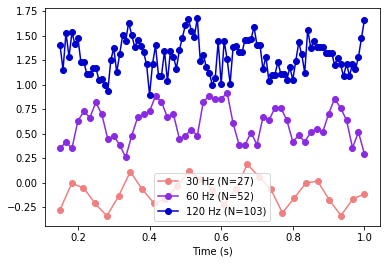

In [6]:
osc_label = 'Rand walk + osc'
analysis_meth = 'AR surr'

for fs, res in examples[osc_label][analysis_meth].items():
    try:
        t = res['t_agg']
        x = res['x_agg']
    except KeyError:
        t = res['t']
        x = res['x']
    y_adj = -3.5 + np.log(fs)
    plt.plot(t, x + y_adj,
             '-o',
             label=f'{fs} Hz (N={len(res["t"])})',
             color=colors_fs[fs])
plt.xlabel('Time (s)')
plt.legend()

Because the higher sampling rates have fewer data points at each time lag, those signals are noisier.

Next, lets look at the spectra, to make sure our simulated oscillation appears at the expected frequency.

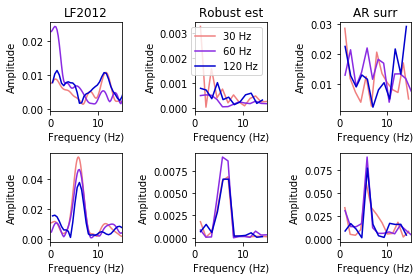

In [7]:
for i_meth, analysis_meth in enumerate(exp_functions.keys()):
    for i_osc, osc_label in enumerate(osc_parameters.keys()):
        plt.subplot(len(osc_parameters),
                    len(exp_functions),
                    (len(exp_functions) * i_osc) + i_meth + 1)
        if i_osc == 0:
            plt.title(analysis_meth)
            
        for fs, res in examples[osc_label][analysis_meth].items():
            # Normalize amp by signal length (for visualization only)
            if analysis_meth in ('AR surr', 'LF2012'):
                y = res['y_emp'] / fs
            else:
                y = res['y_emp']
            plt.plot(res['f'], y, '-',
                     label=f'{fs} Hz',
                     color=colors_fs[fs])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.xlim(0, 15)
        if osc_label == 'Rand walk' and analysis_meth == 'Robust est':
                plt.legend()

plt.tight_layout()

In these examples of simulations that include an oscillation (bottom row), we see that the peak appears at the same expected location (6 Hz) regardless of the sampling rate.

In [8]:
# Look at the frequency resolution
for i_meth, analysis_meth in enumerate(exp_functions.keys()):
    for fs, res in examples['Rand walk'][analysis_meth].items():
        # Look at the frequency resolution
        msg = f"{analysis_meth} {fs} Hz: "\
              f"{np.diff(res['f'])[0]:.2f} Hz"
        print(msg)

LF2012 30 Hz: 0.12 Hz
LF2012 60 Hz: 0.23 Hz
LF2012 120 Hz: 0.47 Hz
Robust est 30 Hz: 1.15 Hz
Robust est 60 Hz: 1.15 Hz
Robust est 120 Hz: 1.18 Hz
AR surr 30 Hz: 1.11 Hz
AR surr 60 Hz: 1.15 Hz
AR surr 120 Hz: 1.17 Hz


For the AR surrogate and robust est. analyses, the frequency resolution changes slightly with changing sampling rate. This happens because the number of samples in the different time-series does not exactly match the sampling rate, when the time-range cannot be evenly split into the expected number of bins. For example, with the AR surrogate method, we have 27 points in the time-series at 30 Hz (ratio: 0.9), and 52 points in the time series at 60 Hz (ratio: 0.867).

For the LF2012 analysis, the frequency resolution is halved with increasing sampling rate. This happens because the time-series is always padded out to the same number of samples.

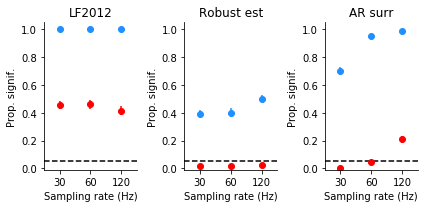

In [9]:
def prop_ci(p, n):
    """ 95% CI of a proportion
    """
    return 1.96 * np.sqrt((p * (1 - p)) / n)

plt.figure(figsize=(6, 3))
for i_plot, analysis_meth in enumerate(exp_functions.keys()):
    plt.subplot(1, 3, i_plot + 1)
    plt.title(analysis_meth)
    plt.axhline(y=0.05, color='k', linestyle='--')
    for osc_label in osc_parameters.keys():
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        x_pos = np.arange(float(len(psig)))
        psig = np.array(list(psig.values()))
        plt.errorbar(x_pos, psig,
                     yerr=prop_ci(psig, n_exp),
                     fmt='o',
                     color=colors[osc_label],
                     label=osc_label)
    plt.xticks(x_pos, labels)
    plt.xlim([-0.5, len(psig) - 0.5])
    plt.xlabel('Sampling rate (Hz)')
    plt.ylim(-0.01, 1.05)
    plt.ylabel('Prop. signif.')
    remove_topright_axes()
    # if i_plot == 1:
    #     plt.legend()
plt.tight_layout()
plt.savefig(f"{plot_dir}sampling rate.eps")

## Statistical tests

### Differences between sampling rates

We can test for differences in how the different analysis methods deal with different sampling rates.

Look within each analysis method across the different sampling rates.

In [10]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    for osc_label in osc_parameters.keys():
        print('-', osc_label)
        psig = prop_signif[osc_label][analysis_meth]
        labels = psig.keys()
        for comp in itertools.combinations(samp_rates, 2):
            msg = f' - {comp[0]} vs {comp[1]}: '
            # Make a contingency table
            p0 = psig[comp[0]]
            p1 = psig[comp[1]]
            tbl = [[p0 * n_exp, p1 * n_exp],
                   [(1 - p0) * n_exp, (1 - p1) * n_exp]]
            tbl = np.array(tbl)
            msg += chi_square_report(tbl)
            print(msg)

LF2012
- Rand walk
 - 30 vs 60: $\chi^2(1) = 0.0$, $p = 0.9$, $\phi_C = 0.00$ [0.00, 0.05]
 - 30 vs 120: $\chi^2(1) = 3.3$, $p = 0.07$, $\phi_C = 0.04$ [0.00, 0.09]
 - 60 vs 120: $\chi^2(1) = 3.9$, $p = 0.05$, $\phi_C = 0.05$ [0.01, 0.09]
- Rand walk + osc
 - 30 vs 60: Can't compute chi-square; at floor/ceiling
 - 30 vs 120: Can't compute chi-square; at floor/ceiling
 - 60 vs 120: Can't compute chi-square; at floor/ceiling
Robust est
- Rand walk
 - 30 vs 60: $\chi^2(1) = 0.3$, $p = 0.6$, $\phi_C = 0.02$ [0.00, 0.06]
 - 30 vs 120: $\chi^2(1) = 0.0$, $p = 0.9$, $\phi_C = 0.01$ [0.00, 0.05]
 - 60 vs 120: $\chi^2(1) = 0.7$, $p = 0.4$, $\phi_C = 0.02$ [0.00, 0.06]
- Rand walk + osc
 - 30 vs 60: $\chi^2(1) = 0.2$, $p = 0.7$, $\phi_C = 0.01$ [0.00, 0.05]
 - 30 vs 120: $\chi^2(1) = 23.6$, $p = 1 \times 10^{-06}$, $\phi_C = 0.11$ [0.07, 0.15]
 - 60 vs 120: $\chi^2(1) = 19.4$, $p = 1 \times 10^{-05}$, $\phi_C = 0.10$ [0.05, 0.14]
AR surr
- Rand walk
 - 30 vs 60: $\chi^2(1) = 30.2$, $p = 4 \times

Compare between methods for a given sampling rate

In [11]:
for samp_rate in samp_rates:
    print(samp_rate)
    for osc_label in osc_parameters.keys():
        print('-', osc_label)
        labels = psig.keys()
        for comp in itertools.combinations(exp_functions.keys(), 2):
            msg = f' - {comp[0]} vs {comp[1]}: '
            # Make a contingency table
            p0 = prop_signif[osc_label][comp[0]][samp_rate]
            p1 = prop_signif[osc_label][comp[1]][samp_rate]
            tbl = [[p0 * n_exp, p1 * n_exp],
                   [(1 - p0) * n_exp, (1 - p1) * n_exp]]
            tbl = np.array(tbl)
            msg += chi_square_report(tbl)
            print(msg)

30
- Rand walk
 - LF2012 vs Robust est: $\chi^2(1) = 524.9$, $p = 4 \times 10^{-116}$, $\phi_C = 0.51$ [0.48, 0.54]
 - LF2012 vs AR surr: $\chi^2(1) = 570.8$, $p = 4 \times 10^{-126}$, $\phi_C = 0.54$ [0.51, 0.56]
 - Robust est vs AR surr: $\chi^2(1) = 7.1$, $p = 0.008$, $\phi_C = 0.06$ [0.02, 0.10]
- Rand walk + osc
 - LF2012 vs Robust est: $\chi^2(1) = 872.8$, $p = 8 \times 10^{-192}$, $\phi_C = 0.66$ [0.64, 0.69]
 - LF2012 vs AR surr: $\chi^2(1) = 350.6$, $p = 3 \times 10^{-78}$, $\phi_C = 0.42$ [0.39, 0.45]
 - Robust est vs AR surr: $\chi^2(1) = 191.3$, $p = 2 \times 10^{-43}$, $\phi_C = 0.31$ [0.27, 0.35]
60
- Rand walk
 - LF2012 vs Robust est: $\chi^2(1) = 544.3$, $p = 2 \times 10^{-120}$, $\phi_C = 0.52$ [0.50, 0.55]
 - LF2012 vs AR surr: $\chi^2(1) = 456.8$, $p = 2 \times 10^{-101}$, $\phi_C = 0.48$ [0.45, 0.51]
 - Robust est vs AR surr: $\chi^2(1) = 13.7$, $p = 0.0002$, $\phi_C = 0.09$ [0.05, 0.13]
- Rand walk + osc
 - LF2012 vs Robust est: $\chi^2(1) = 852.3$, $p = 2 \times 1

### Comparing false positives against alpha = 0.05

Does each method have a rate of false positives higher than 0.05? If so, that method does not adequately control the rate of false positives. Those methods are marked with an asterisk `*`.

In [12]:
for analysis_meth in exp_functions.keys():
    print(analysis_meth)
    for samp_rate in samp_rates:
        prop = prop_signif['Rand walk'][analysis_meth][samp_rate]
        pval = stats.binom_test(prop * n_exp,
                                n_exp,
                                0.05,
                                alternative='greater')
        msg = f'- {samp_rate}: {prop:.2f}, p = {pval:.1e}'
        if prop > 0.05 and pval < 0.05:
            msg += ' *'
        print(msg)

LF2012
- 30: 0.46, p = 2.5e-308 *
- 60: 0.46, p = 3.7e-313 *
- 120: 0.41, p = 1.6e-260 *
Robust est
- 30: 0.02, p = 1.0e+00
- 60: 0.01, p = 1.0e+00
- 120: 0.02, p = 1.0e+00
AR surr
- 30: 0.01, p = 1.0e+00
- 60: 0.04, p = 8.3e-01
- 120: 0.21, p = 2.4e-68 *
